## In this file, we try to predict spread
We are using BERT model to predict the spread of the assets with the following steps:
- Using spreads.csv -- has columns: 'Date', 'Ticker Pair', 'Spread', and 'Return'
- Making a texts column takin  

Desired output format: 'Date', 'Ticker Pair', 'Spread', 'Return'


In [1]:
#%pip install transformers torch

In [20]:
import pandas as pd

# load financial data -- Note we have the following columns: Date, Ticker Pair, BERT Spread, BERT Position
data = pd.read_csv('outputs/spreads_weekly_small.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.rename(columns={"Ticker Pair": "Ticker_Pair"}, inplace=True)
data[["tick1", "tick2"]] = data["Ticker_Pair"].str.split("-", expand=True)
# create text description for BERT to process
data['texts'] = [f"The spread for {row['Ticker_Pair']} on {row['Date'].strftime('%Y-%m-%d')} is {row['Spread']}" for index, row in data.iterrows()]


data.head()

,Date,Ticker_Pair,Spread,Return,tick1,tick2,texts
0,2016-01-10,AAPL-MSFT,-0.544055,NaN,AAPL,MSFT,The spread for AAPL-MSFT on 2016-01-10 is -0.5...
1,2016-01-17,AAPL-MSFT,-0.165858,0.027360,AAPL,MSFT,The spread for AAPL-MSFT on 2016-01-17 is -0.1...
2,2016-01-24,AAPL-MSFT,0.080579,0.018672,AAPL,MSFT,The spread for AAPL-MSFT on 2016-01-24 is 0.08...
3,2016-01-31,AAPL-MSFT,-1.192595,-0.093776,AAPL,MSFT,The spread for AAPL-MSFT on 2016-01-31 is -1.1...
4,2016-02-07,AAPL-MSFT,-0.312257,0.060624,AAPL,MSFT,The spread for AAPL-MSFT on 2016-02-07 is -0.3...


In [21]:
# import the bert tokenizer
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np


texts = data['texts'].values
spread = data['Spread'].values
print(f'Data Loaded: {len(data)} rows')
print(f'Spread distribution {sum(spread)}, {len(spread) - sum(spread)}')


## Change this for the actual task -- we will just train and predict on unseen data
# create the train/test split for regression task
train_texts, test_texts, train_spreads, test_spreads = train_test_split(
    texts, spread, test_size=0.2, random_state=42)
print(f'Train Size: {len(train_texts)}, Test Size: {len(test_texts)}')


# tokenize and encode the data using a pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# tokenize training data
train_encodings = tokenizer(
    list(train_texts), padding=True, truncation=True, return_tensors='pt', max_length=128
)
## This will not be necessary
# tokenize test data
test_encodings = tokenizer(
    list(test_texts), padding=True, truncation=True, return_tensors='pt', max_length=128
)

# Convert spread values to float tensors for regression
train_dataset = TensorDataset(train_encodings['input_ids'], 
                            train_encodings['attention_mask'], 
                            torch.tensor(train_spreads, dtype=torch.float32))
test_dataset = TensorDataset(test_encodings['input_ids'], 
                           test_encodings['attention_mask'], 
                           torch.tensor(test_spreads, dtype=torch.float32))

# create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



# loading the BERT model
from transformers import BertPreTrainedModel, BertModel

class BertForRegression(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.regressor = torch.nn.Sequential(
            torch.nn.Dropout(config.hidden_dropout_prob),  # Fixed: torch.nn.Dropout instead of torch.nnDropout
            torch.nn.Linear(config.hidden_size, 1)  # Output layer for regression
        )
        self.init_weights()
    
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, **kwargs):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,  
        )
        pooled_output = outputs.pooler_output
        return self.regressor(pooled_output)

# loading the BERT model for regression (num_labels=1 for regression)
model = BertForRegression.from_pretrained('bert-base-uncased', 
                                         config=BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1).config)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# fine tune the model
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5) # higher learning rate for regression

# Using MSE for loss regression
loss_fn = torch.nn.MSELoss()

# epochs means one complete pass through the entire training dataset. 
# epoch 1: the model sees all training data once and makes initial adjustments
# epoch 2: the model sees the data again, learns from its previous mistakes, and makes further adjustments
# epoch 3: the model sees the data a third time, refines its understanding, and makes final adjustments
# In this case, we will use 3 epochs for training.
num_epochs = 5 # increased from 3 for regression task 

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_loader:
        input_ids, attention_mask, batch_spreads = [b.to(device) for b in batch]
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        # Reshape outputs to match target shape
        outputs = outputs.squeeze(-1)
        
        # Calculate regression loss
        loss = loss_fn(outputs, batch_spreads)
        
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {total_loss / len(train_loader):.6f}")

# Evaluation
model.eval()
all_preds = []
all_spreads = []
eval_loss = 0

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, batch_spreads = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        outputs = outputs.squeeze(-1)
        
        # Calculate loss
        loss = loss_fn(outputs, batch_spreads)
        eval_loss += loss.item()
        
        all_preds.extend(outputs.cpu().numpy())
        all_spreads.extend(batch_spreads.cpu().numpy())

print(f"Evaluation Loss: {eval_loss / len(test_loader):.6f}")

# Calculate regression metrics
mse = mean_squared_error(all_spreads, all_preds)
mae = mean_absolute_error(all_spreads, all_preds)
r2 = r2_score(all_spreads, all_preds)

print(f"Mean Squared Error: {mse:.6f}")
print(f"Mean Absolute Error: {mae:.6f}")
print(f"R^2 Score: {r2:.6f}")



Data Loaded: 51 rows
Spread distribution -14.582626511517802, 65.5826265115178
Train Size: 40, Test Size: 11


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['regressor.1.bias', 'regressor.1.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Average Loss: 0.249906
Epoch 2/5, Average Loss: 0.245534
Epoch 3/5, Average Loss: 0.221388
Epoch 4/5, Average Loss: 0.218850
Epoch 5/5, Average Loss: 0.148426
Evaluation Loss: 0.158175
Mean Squared Error: 0.158175
Mean Absolute Error: 0.303867
R^2 Score: 0.462779


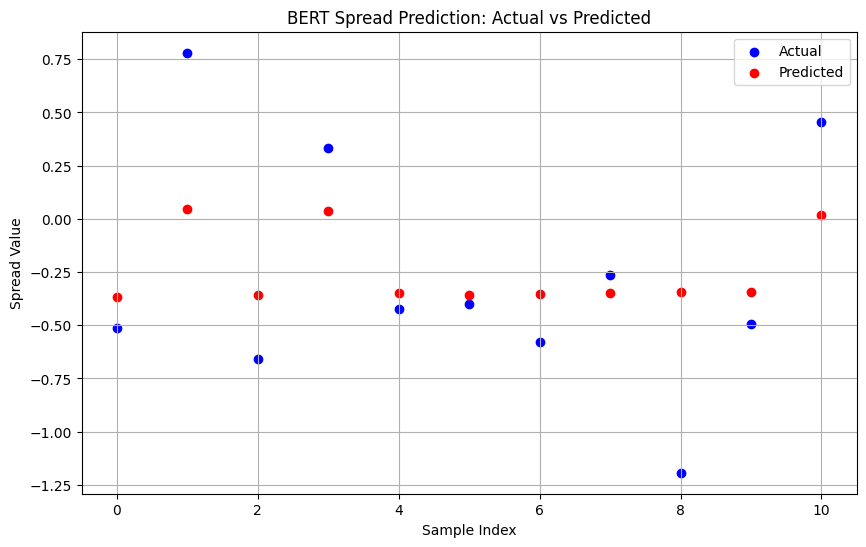

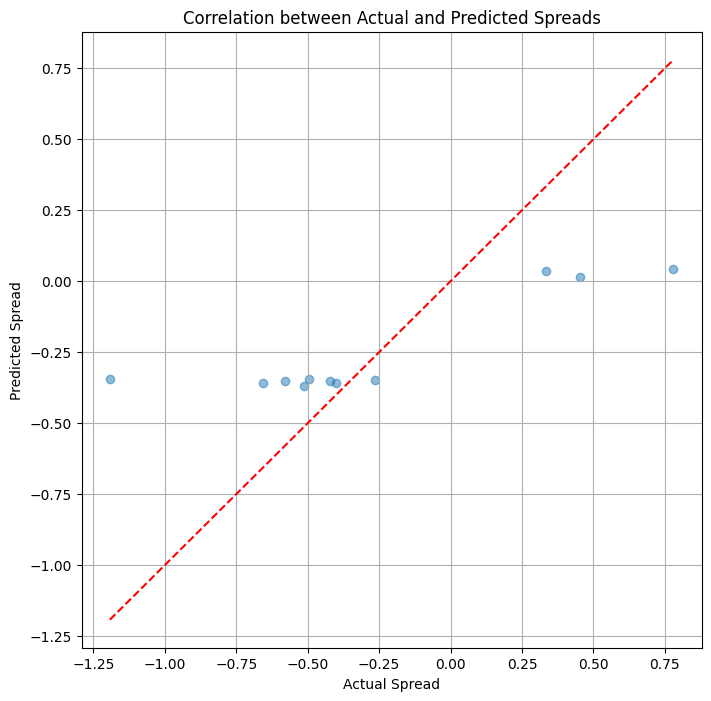

In [22]:
# Visualize predictions vs actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# Plot sample of predictions (first 100 points)
sample_size = min(100, len(all_preds))
plt.scatter(range(sample_size), all_spreads[:sample_size], color='blue', label='Actual')
plt.scatter(range(sample_size), all_preds[:sample_size], color='red', label='Predicted')
plt.title('BERT Spread Prediction: Actual vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Spread Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot correlation
plt.figure(figsize=(8, 8))
plt.scatter(all_spreads, all_preds, alpha=0.5)
plt.plot([min(all_spreads), max(all_spreads)], [min(all_spreads), max(all_spreads)], 'r--')
plt.xlabel('Actual Spread')
plt.ylabel('Predicted Spread')
plt.title('Correlation between Actual and Predicted Spreads')
plt.grid(True)
plt.show()

In [28]:
# predict for the following dates: 1/1/2019 - 12/31/2019
# Do monthly predictions for a year after the training data
# input data set has weekly returns

# getting the last date in the training data
last_date = data['Date'].max()
print(f'Last date in training data: {last_date}')

# create a date range for the next year
start_date = last_date + pd.DateOffset(days=1)  
end_date = start_date + pd.DateOffset(years=1)  
date_range = pd.date_range(start=start_date, end=end_date, freq='W')  # Weekly frequency

print(f'Predictions for the following dates: {date_range}')

# Get unique ticker pairs from the dataset
ticker_pairs = data['Ticker_Pair'].unique()
print(f'Found {len(ticker_pairs)} unique ticker pairs')

# Create a DataFrame to store all predictions
all_predictions = []

# Set model to evaluation mode
model.eval()

# For each ticker pair, make predictions for all future dates
for ticker_pair in ticker_pairs:
    # Create predictions for each date
    for prediction_date in date_range:
        formatted_date = prediction_date.strftime('%Y-%m-%d')
        
        # Create input text in the same format as training data
        # Using 0.0 as a placeholder
        input_text = f"The spread for {ticker_pair} on {formatted_date} is 0.0"
        
        # Tokenize the input text
        inputs = tokenizer(
            input_text, 
            padding=True, 
            truncation=True, 
            return_tensors='pt', 
            max_length=128
        ).to(device)
        
        # Make prediction
        with torch.no_grad():
            outputs = model(**inputs)
            predicted_spread = outputs.squeeze().item()
        
        # Determine position based on predicted spread
        # Positive spread typically indicates a buy signal (1), negative a sell signal (0)
        position = 'buy' if predicted_spread > 0 else 'sell'
        
        # Add to predictions list
        all_predictions.append({
            'Date': prediction_date,
            'Ticker_Pair': ticker_pair,
            'BERT_Spread': predicted_spread,
            'BERT_Position': position
        })

# Convert list of dictionaries to DataFrame
predictions = pd.DataFrame(all_predictions)

# Sort by date and ticker pair
predictions = predictions.sort_values(['Date', 'Ticker_Pair'])

# Display the first few predictions
print("\nPredictions head:")
print(predictions.head())

# Save predictions to CSV
predictions.to_csv('outputs/bert_spread.csv', index=False)
print(f"Saved {len(predictions)} predictions to 'outputs/bert_spread_predictions.csv'")

Last date in training data: 2016-12-25 00:00:00
Predictions for the following dates: DatetimeIndex(['2017-01-01', '2017-01-08', '2017-01-15', '2017-01-22',
               '2017-01-29', '2017-02-05', '2017-02-12', '2017-02-19',
               '2017-02-26', '2017-03-05', '2017-03-12', '2017-03-19',
               '2017-03-26', '2017-04-02', '2017-04-09', '2017-04-16',
               '2017-04-23', '2017-04-30', '2017-05-07', '2017-05-14',
               '2017-05-21', '2017-05-28', '2017-06-04', '2017-06-11',
               '2017-06-18', '2017-06-25', '2017-07-02', '2017-07-09',
               '2017-07-16', '2017-07-23', '2017-07-30', '2017-08-06',
               '2017-08-13', '2017-08-20', '2017-08-27', '2017-09-03',
               '2017-09-10', '2017-09-17', '2017-09-24', '2017-10-01',
               '2017-10-08', '2017-10-15', '2017-10-22', '2017-10-29',
               '2017-11-05', '2017-11-12', '2017-11-19', '2017-11-26',
               '2017-12-03', '2017-12-10', '2017-12-17', '2017-

In [24]:
# predict for the following dates: 1/1/2019 - 12/31/2019
# Do monthly predictions for a year after the training data
# input data set has weekly returns

# getting the last date in the training data
last_date = data['Date'].max()
print(f'Last date in training data: {last_date}')

# create a date range for the next year
start_date = last_date + pd.DateOffset(days=1)  # Start from the next day after the last date
end_date = start_date + pd.DateOffset(years=1)  # One year later
date_range = pd.date_range(start=start_date, end=end_date, freq='W')  # Weekly frequency

print(f'Predictions for the following dates: {date_range}')

# get unique ticker pairs from the training data
ticker_pairs = data['Ticker_Pair'].unique()
print(f'Unique Ticker Pairs: {ticker_pairs}')

# create a new DataFrame for the predictions
all_predictions = []
# set model to evaluation mode:
model.eval()

# for each ticker pair, make predictions for all future dates
for ticker_pair in ticker_pairs:
    # create predictions for each datae
    for prediction_date in date_range:
        formatted_date = prediction_date.strftime('%Y-%m-%d')

        # create input text in the same format as training data
        input_text = f"The spread for {ticker_pair} on {formatted_date} is 0.0"  # Placeholder spread value

        # tokenize the input text
        inputs = tokenizer(
            input_text, padding=True, truncation=True, return_tensors='pt', max_length=128
        ).to(device)

        # make prediction
        with torch.no_grad():
            outputs = model(**inputs)
            predicted_spread = outputs.squeeze().item()
        
        # determine the position based on predicted spread
        position = 1 if predicted_spread > 0 else 0
    
        # add predictions to the list
        all_predictions.append(pd.DataFrame({
            'Date': date_range,
            'Ticker_Pair': ticker_pair,
            'BERT_Spread': all_preds,
            'BERT_Position': [1 if pred > 0 else 0 for pred in all_preds]  # Binary position based on spread
    }))

# convert list of dictionaries to df
predictions = pd.concat(all_predictions)

# sort by date and ticker pair
predictions.sort_values(by=['Date', 'Ticker_Pair'])

print("\npredictions head")
print(predictions.head())
# save predictions to csv
predictions.to_csv('outputs/bert_spreads.csv', index=False)
print(f"Predictions saved to outputs/bert_spreads.csv")




Last date in training data: 2016-12-25 00:00:00
Predictions for the following dates: DatetimeIndex(['2017-01-01', '2017-01-08', '2017-01-15', '2017-01-22',
               '2017-01-29', '2017-02-05', '2017-02-12', '2017-02-19',
               '2017-02-26', '2017-03-05', '2017-03-12', '2017-03-19',
               '2017-03-26', '2017-04-02', '2017-04-09', '2017-04-16',
               '2017-04-23', '2017-04-30', '2017-05-07', '2017-05-14',
               '2017-05-21', '2017-05-28', '2017-06-04', '2017-06-11',
               '2017-06-18', '2017-06-25', '2017-07-02', '2017-07-09',
               '2017-07-16', '2017-07-23', '2017-07-30', '2017-08-06',
               '2017-08-13', '2017-08-20', '2017-08-27', '2017-09-03',
               '2017-09-10', '2017-09-17', '2017-09-24', '2017-10-01',
               '2017-10-08', '2017-10-15', '2017-10-22', '2017-10-29',
               '2017-11-05', '2017-11-12', '2017-11-19', '2017-11-26',
               '2017-12-03', '2017-12-10', '2017-12-17', '2017-

ValueError: All arrays must be of the same length